In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Differentiable Agent-Based Models

In previous notebooks we learned how automatic differentiation (AD) can be used to obtain gradients from stochastic computer programs. Next, we will use what we have learned to implement several differentiable programs, including a differentiable agent-based model (ABM).

<!-- We are now in a good spot to code our first differentiable ABM. Refer to notebooks 1 and 2 for a review of automatic differentiation (AD). -->

## The Random Walk

To begin let's implement a one-dimensonal random walk. Recall that a one-dimensional random walk is given by the following recursion:

$$
x_{t+1} = x_t + \begin{cases}1 &\mathrm{if} &\xi = 1 \\ -1 &\mathrm{if} &\xi = 0\end{cases}, \quad \xi \sim \mathrm{Bern}({\theta})
$$

where  $\text{Bern}$ denotes the Bernoulli distribution, $x_{t}$ denotes the position observed after $t$ steps, and $\theta$ denotes a parameter determining the probability of moving in the positive direction. Let's use PyTorch to implement this model as a stochastic program called `random_walk`.

In [2]:
def random_walk(theta, n_timesteps):
    x = torch.tensor([0.])
    for i in range(n_timesteps-1):
        xi = torch.distributions.Bernoulli(theta).sample()
        if xi == 1:
            next_x = x[-1] + 1
        else:
            next_x = x[-1] - 1
        x = torch.hstack((x, next_x))
    return x

Let's forward simulate our stochastic program to make sure everything is working correclty!

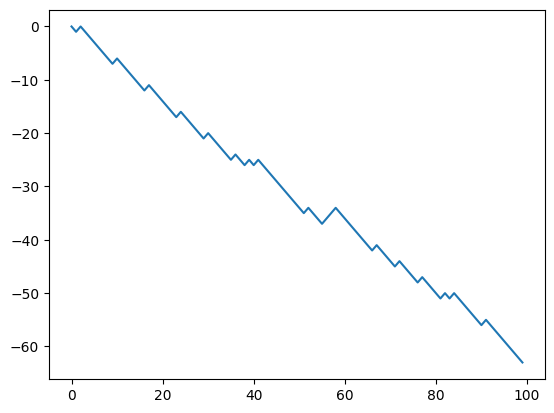

In [3]:
theta = 0.2
n_timesteps = 100
x = random_walk(theta, n_timesteps)
plt.plot(x)

Now that we are confident the model is correclty implemented, let's check whether PyTorch can compute a gradient.  Since `random_walk` returns a time series and has one parameter the Jacobian,

$$
(J)_t = \frac{\partial {x_t}}{\partial \theta},
$$

will be a row vector. Let's plot the Jacobian at $\theta = 0.2$ by using the `torch.autograd` module.

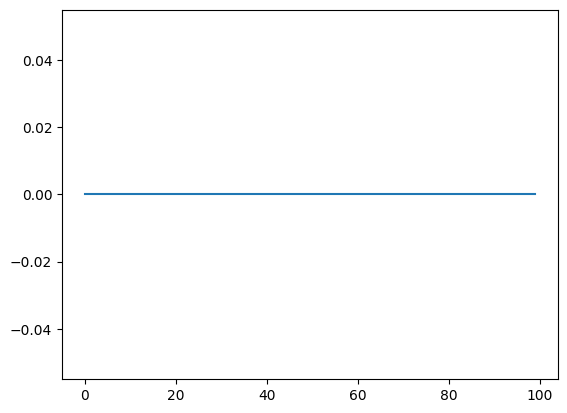

In [4]:
dx_dtheta = torch.autograd.functional.jacobian(
    lambda x: random_walk(theta=x, n_timesteps=n_timesteps), torch.tensor(theta)
)
plt.plot(dx_dtheta)

We immediately see that all entries of the Jacobian are zero! This is happening for two reasons. Firstly, as we saw in the previous notebook, the Bernoulli distribution is not differentiable by default and we need to a use technique like the Gumbel-Softmax trick to differentiate through it. We can implement the Gumbel-Sofxmax trick in ``random walk`` by replacing

```python
 xi = torch.distributions.Bernoulli(theta).sample()
``` 

with 

```python
logits = torch.hstack((theta, 1 - theta)).log()
xi = torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=True)[0]
```

There is also an issue with control flow. Under the hood, PyTorch builds a **static computational graph**. This means that the structure of the computational graph cannot change at run-time based on the outcome of control flow statements. As a result, the gradient will not correctly flow backwards through `if` statements that depend on the parameters we want to differentiate with respect to. Analysing the code of `random_walk` we find the following control flow statement:

```python
xi = torch.distributions.Bernoulli(theta).sample()
if xi == 1:
    next_x = x[-1] + 1
else:
    next_x = x[-1] - 1
```

Since the `if` statement predicate depends on `xi` which in turn depends on `theta`, the gradient will not flow backwards properly. To fix this issue, we can reimplement the `if` statement using  **masking**.

```python
xi = torch.distributions.Bernoulli(theta)
next_x = xi * (x[-1] + 1) + (1-xi) * (x[-1] - 1)
```

Note that if `xi = 1` then `next_x` will be equal to `x[-1] +1` as `(1-xi)` will be equal to zero. That is, the `else` output of the original `if` statement is *masked out*. Likewise, if `xi = 0` then `next_x` will be equal to `x[-1] - 1` as the output `(x[-1] + 1)` is masked out by its multiplier `xi`. In other words, the code above is completely equivalent to the previous `if` statement. Moreover this code will play nicely with the static compuational graph generated by PyTorch as it contains no control flow statements.

Let's rewrite `random_walk` to implement both masking and the Gumbel-Softmax trick!

<!-- We obtain a gradient of 0. Why is that? There are two reasons:

1. As we noted in the previous tutorials, the Bernoulli distribution is not automatically differentiable, and we need to use a continuous relaxation such as Gumbel-Softmax.
2. AD frameworks such as PyTorch require a static computation graph to perform AD. Even though they support control flow statement such as `if` or `else`, they do not support control flow statements that depend on the parameters that we want to differentiate to. This can be circumvented by using masks. That is, a statement

```python
xi = torch.distributions.Bernoulli(theta)
if x:
    return a
else:
    return b
```

can be written as

```python
xi = torch.distributions.Bernoulli(theta)
y = xi * a + (1-xi) * b
```

with this in mind, we can rewrite our example as: -->


In [5]:
def random_walk(theta, n_timesteps, tau=0.1):
    x = torch.tensor([0.0])
    for i in range(n_timesteps - 1):
        logits = torch.hstack((theta, 1 - theta)).log()
        xi = torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=True)[0]
        next_x = x[-1] + 2 * xi - 1
        x = torch.hstack((x, next_x))
    return x

Let's run a simulation to check our model runs properly.

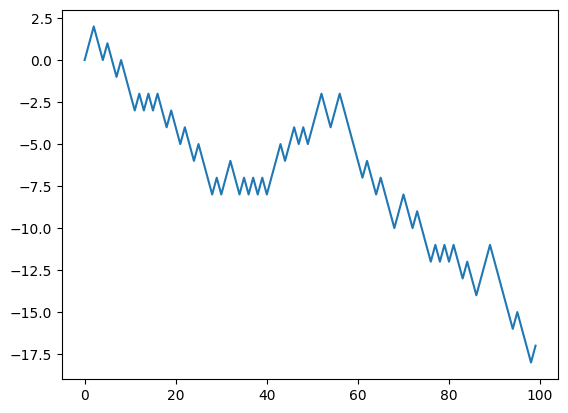

In [6]:
theta = torch.tensor(0.4)
n_timesteps = 100
x = random_walk(theta, n_timesteps)
plt.plot(x)

Both implementations of `random_walk` behave identically. Any difference observed between simulation outputs is caused by the randomness of the Bernoulli distribution. This is because we set `hard=True` when employing the Gumbel-Softmax trick, ensuring that the Bernoulli distribution is only replaced by a continuous relaxation when applying the chain rule during the backwards pass. If the previous sentence is confusing, you should review the previous notebook. Let's check the Jacobian again!

<!-- Now, remember, because of the `hard=True` the forward simulation is identical to the previous case. That is, the continuous relaxation that we model with Gumbel-Softmax only affects the backward gradient propagation. Let us now recompute the jacobian: -->

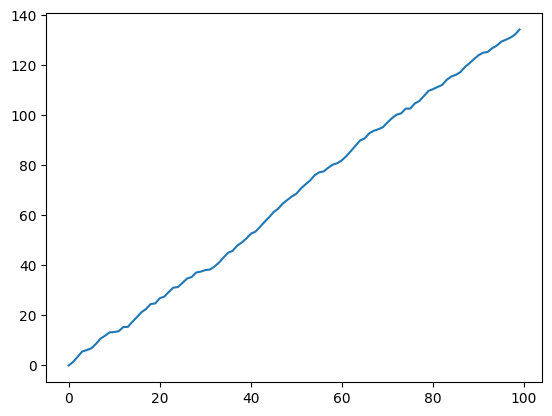

In [7]:
dx_dtheta = torch.autograd.functional.jacobian(
    lambda x: random_walk(theta=x, n_timesteps=n_timesteps, tau=1.0), theta
)
plt.plot(dx_dtheta)

PyTorch is now giving us non-zero derivatives thanks to our changes. Recall that the bias-variance trade-off of the Gumbel-Softmax trick is controlled implicitly by setting the temperatrue $\tau$. Let's investigate this trade-off in the context of the random walk. Thankfully, the exact analytical gradient is easy to derive for the random walk:

$$
\begin{align}
\frac{\partial}{\partial \theta} \mathbb E[x_t]  & = \frac{\partial}{\partial \theta} \mathbb E\left[ \sum_{j=1}^{t} 2 \mathrm{Bern(\theta)} - 1 \right]\\
                                                 & = \frac{\partial}{\partial \theta} (2  t  \theta - t) \\
                                                 & = 2t
\end{align}
$$

This means we can compare the gradients output by PyTorch against the analytical gradient for different temperature settings!

<!-- The temperature parameter of the GS distribution entails a bias-variance tradeoff as explained in the previous notebook. Let's analyze the effect here.  -->

In [8]:
taus = [0.1, 0.5, 1.0]
n_gradient_samples = 50
n_timesteps = 50
gradients_per_tau = {tau: [] for tau in taus}
for tau in taus:
    for i in range(n_gradient_samples):
        dx_dtheta = torch.autograd.functional.jacobian(
            lambda x: random_walk(theta=x, n_timesteps=n_timesteps, tau=tau),
            theta,
            vectorize=True,
        )
        gradients_per_tau[tau].append(dx_dtheta)

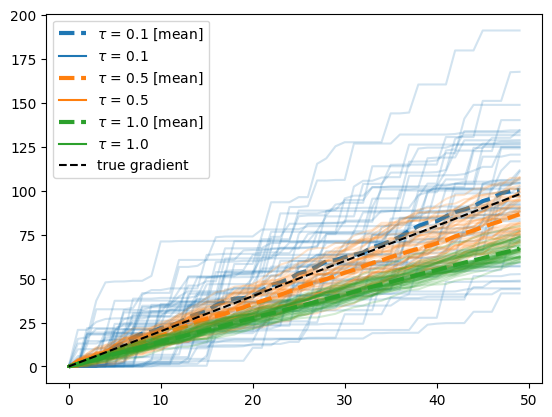

In [12]:
fig, ax = plt.subplots()
for i, tau in enumerate(gradients_per_tau):
    for grad in gradients_per_tau[tau]:
        ax.plot(grad, color=f"C{i}", alpha=0.2)
    ax.plot(
        sum(gradients_per_tau[tau]) / n_gradient_samples,
        color=f"C{i}",
        linestyle="--",
        label=rf"$\tau$ = {tau} [mean]",
        lw=3
    )
    ax.plot([], [], color=f"C{i}", label=rf"$\tau$ = {tau}")
ax.plot(
    range(n_timesteps),
    2 * np.array(range(n_timesteps)),
    color="black",
    linestyle="--",
    label="true gradient",
)
ax.legend()

<!-- First let's address how we obtained the true gradient value by the black dashed line $y=x$. Since the random walk is a linear model, we can write

$$
\begin{align}
\frac{\partial}{\partial \theta} \mathbb E[x_N]  & = \frac{\partial}{\partial \theta} \mathbb E\left[ \sum_{j=1}^{N} 2 \mathrm{Bernoulli(\theta)} - 1 \right]\\
                                                 & = \frac{\partial}{\partial \theta} (2  N  \theta - N) \\
                                                 & = 2 N
\end{align}
$$ -->

Unsurprisingly, as $\tau$ decreases, the mean of each gradient estimate gets closer to the analytical gradient, whilst the variance increases significantly. In this case, it may be more reasonable to use $\tau=0.5$ rather than $\tau=0.1$, since a small increase in bias is compensated by a large reduction in variance.


 <!-- but the variance increases significantly. In this particular case, we may do better with $\tau=0.5$ than $\tau=0.1$ since the small bias is an acceptable trade for a big reduction in variance. -->

## Summary

In this notebook, we used the tools we have learned so far to build a simple differenitable program. In the next notebook, we will see how the same tools can be applied to build a differentiable economic ABM. Moreover, we will finally highlight the advantages of differentiability when it comes to calibration!